Homogeneous Game

Saved history files to game_data/


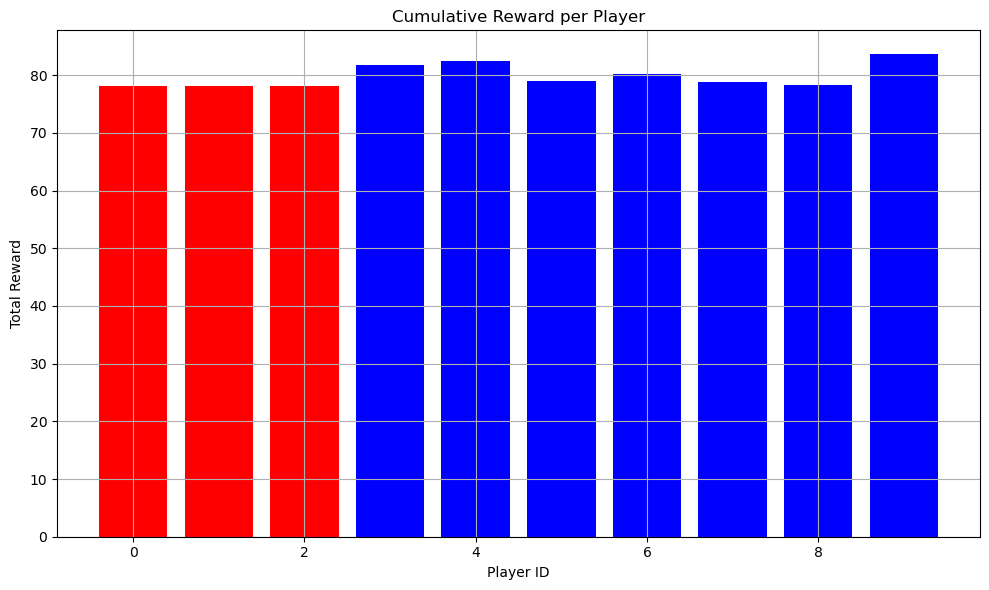

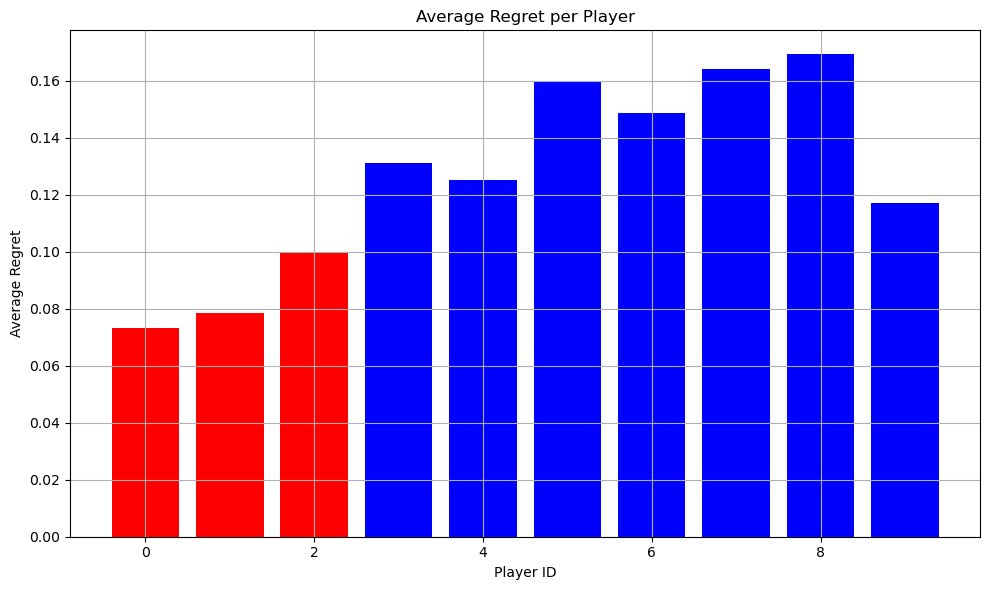

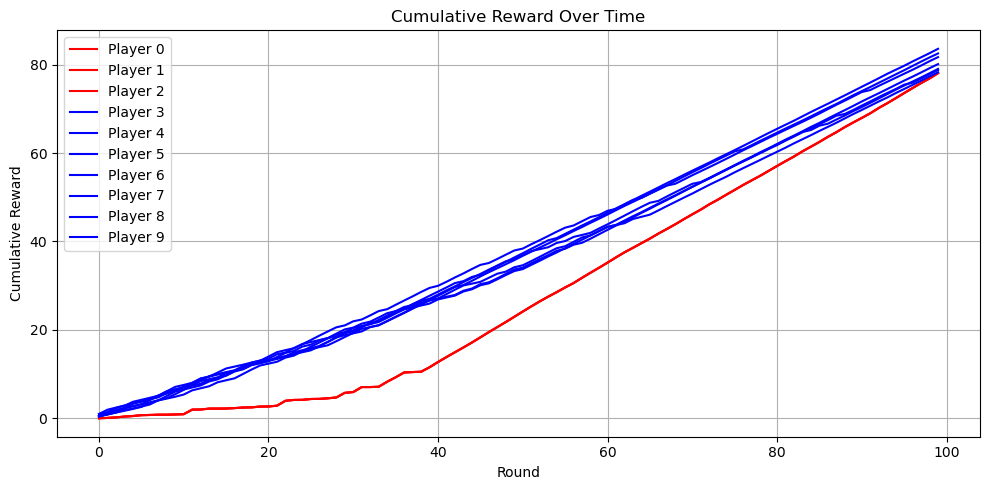

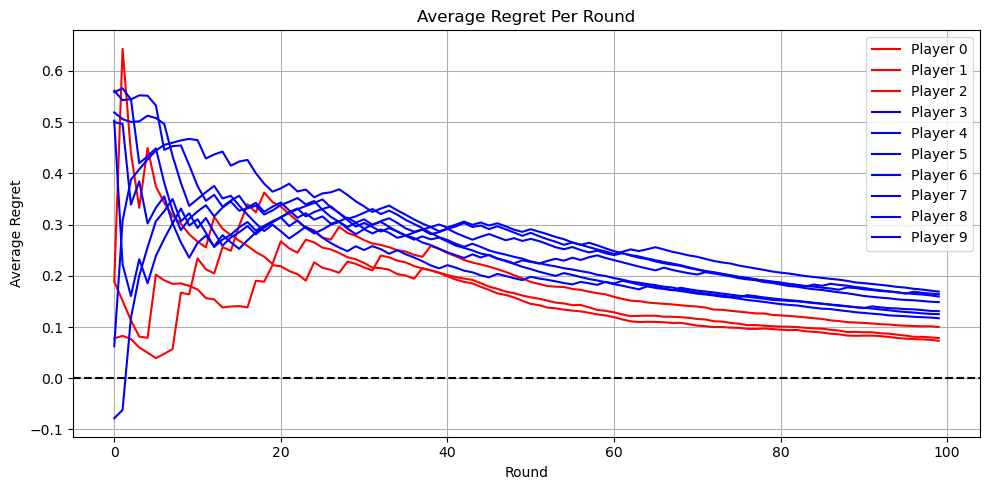

'game_data'

In [25]:
import numpy as np
import os
import matplotlib.pyplot as plt

def compute_payoffs(actions, colluders, honest, num_actions, collusion_reward=1.0, collusion_penalty=0.2):
    num_players = len(actions)
    payoffs = np.zeros(num_players)
    
    if len(colluders) > 0:
        colluder_actions = actions[colluders]
        if np.all(colluder_actions == colluder_actions[0]):
            reward = collusion_reward + 0.2 * np.random.rand()
            payoffs[colluders] = reward
        else:
            penalty = collusion_penalty * np.random.rand()
            payoffs[colluders] = penalty

    for i in honest:
        payoffs[i] = 0.4 + 0.5 * (actions[i] == i % num_actions) + 0.1 * np.random.rand()

    return payoffs

def simulate_game(
    save_dir='game_data',
    num_players=10,
    num_colluders=3,
    num_actions=4,
    num_rounds=100,
    eta=0.1,
    collusion_reward=1.0,
    collusion_penalty=0.2,
    seed=None
):
    if seed is not None:
        np.random.seed(seed)

    players = np.arange(num_players)
    colluding_players = players[:num_colluders]
    honest_players = players[num_colluders:]

    shared_colluder_weights = np.ones(num_actions)
    weights = np.ones((num_players, num_actions))

    history_rewards = np.zeros((num_players, num_rounds))
    history_regrets = np.zeros((num_players, num_rounds))
    history_actions = np.zeros((num_players, num_rounds), dtype=int)

    for t in range(num_rounds):
        colluder_probs = shared_colluder_weights / shared_colluder_weights.sum() if len(colluding_players) > 0 else None
        probs = weights / weights.sum(axis=1, keepdims=True)

        actions = np.zeros(num_players, dtype=int)
        for i in range(num_players):
            if i in colluding_players:
                actions[i] = np.random.choice(num_actions, p=colluder_probs)
            else:
                actions[i] = np.random.choice(num_actions, p=probs[i])

        history_actions[:, t] = actions
        rewards = compute_payoffs(actions, colluding_players, honest_players, num_actions, collusion_reward, collusion_penalty)

        for i in range(num_players):
            counterfactual_payoffs = np.zeros(num_actions)
            for a in range(num_actions):
                counterfactual_action = actions.copy()
                counterfactual_action[i] = a
                counterfactual_payoffs[a] = compute_payoffs(
                    counterfactual_action, colluding_players, honest_players,
                    num_actions, collusion_reward, collusion_penalty
                )[i]

            best_response = np.max(counterfactual_payoffs)
            regret = best_response - rewards[i]

            history_rewards[i, t] = rewards[i]
            history_regrets[i, t] = regret

            if i in colluding_players and len(colluding_players) > 0:
                shared_colluder_weights *= np.exp(eta * counterfactual_payoffs)
            elif i in honest_players:
                weights[i] *= np.exp(eta * counterfactual_payoffs)

    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, 'history_rewards.npy'), history_rewards)
    np.save(os.path.join(save_dir, 'history_regrets.npy'), history_regrets)
    np.save(os.path.join(save_dir, 'history_actions.npy'), history_actions)

    print(f"Saved history files to {save_dir}/")

    cumulative_rewards = history_rewards.sum(axis=1)
    average_regrets = history_regrets.mean(axis=1)

    # Cumulative Reward Plot
    plt.figure(figsize=(10, 6))
    for i in range(num_players):
        color = 'red' if i in colluding_players else 'blue'
        plt.bar(i, cumulative_rewards[i], color=color)
    plt.title("Cumulative Reward per Player")
    plt.xlabel("Player ID")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'cumulative_reward_per_player.png'))
    plt.show()

    # Average Regret Plot
    plt.figure(figsize=(10, 6))
    for i in range(num_players):
        color = 'red' if i in colluding_players else 'blue'
        plt.bar(i, average_regrets[i], color=color)
    plt.title("Average Regret per Player")
    plt.xlabel("Player ID")
    plt.ylabel("Average Regret")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'average_regret_per_player.png'))
    plt.show()

    # Cumulative Reward Over Time
    plt.figure(figsize=(10, 5))
    for i in range(num_players):
        color = 'red' if i in colluding_players else 'blue'
        plt.plot(np.cumsum(history_rewards[i]), label=f'Player {i}', color=color)
    plt.title("Cumulative Reward Over Time")
    plt.xlabel("Round")
    plt.ylabel("Cumulative Reward")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'cumulative_reward_over_time.png'))
    plt.show()

    # Average Regret Per Round
    plt.figure(figsize=(10, 5))
    for i in range(num_players):
        color = 'red' if i in colluding_players else 'blue'
        avg_regret = np.cumsum(history_regrets[i]) / (np.arange(1, num_rounds + 1))
        plt.plot(avg_regret, label=f'Player {i}', color=color)
    plt.title("Average Regret Per Round")
    plt.xlabel("Round")
    plt.ylabel("Average Regret")
    plt.axhline(0, color='black', linestyle='--')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'average_regret_per_round.png'))
    plt.show()

    return save_dir

# Run it
simulate_game(save_dir='game_data', seed=42)


Game Heterogeneous

Saved to game_data_soft_risky


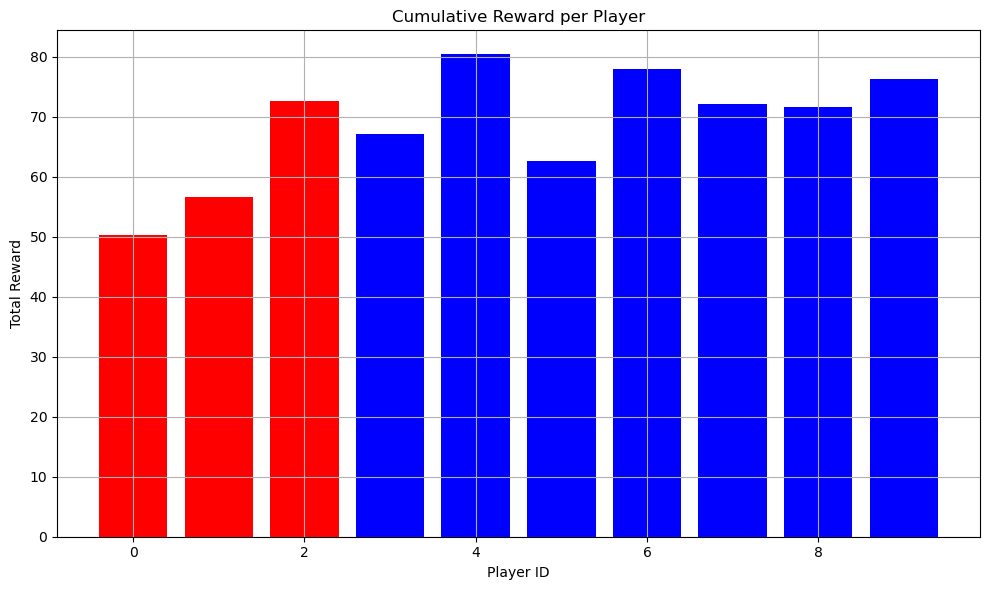

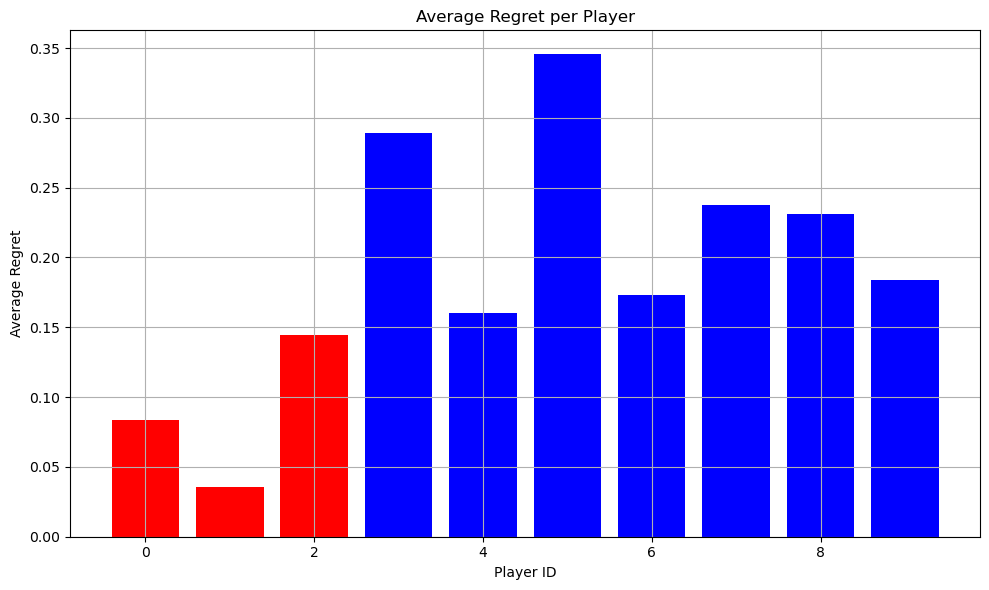

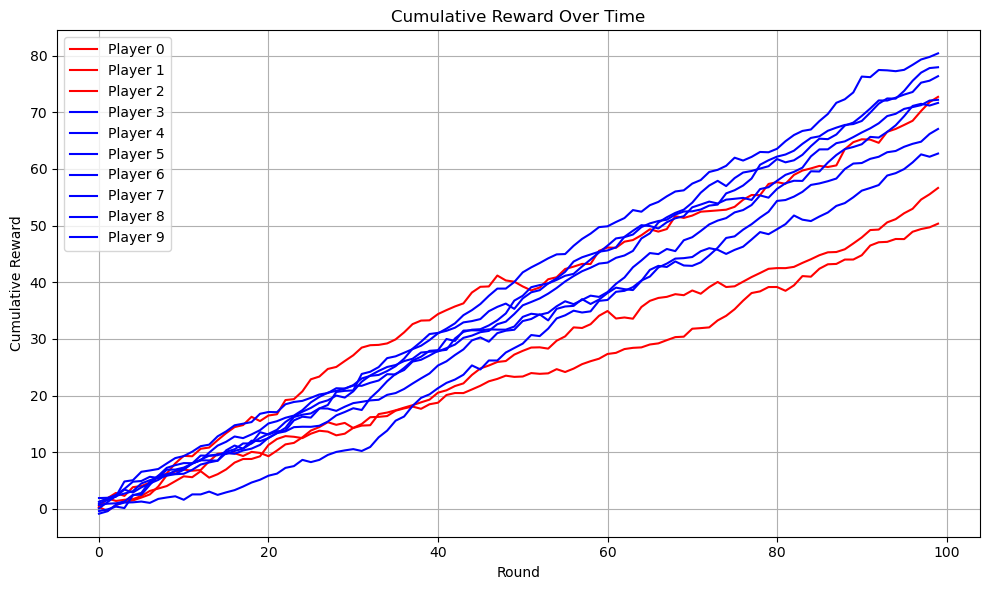

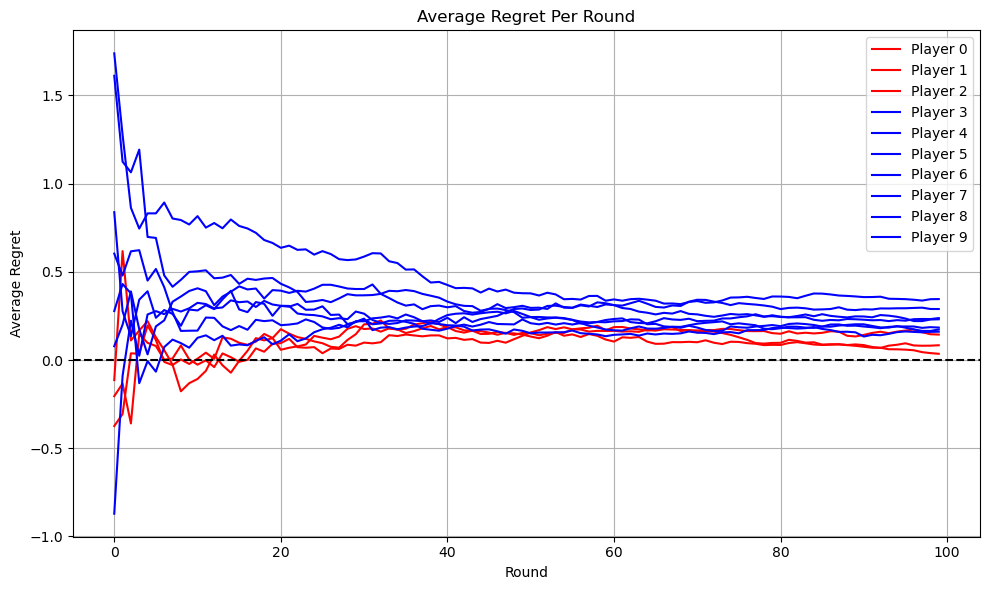

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

def compute_dynamic_collusion_payoffs(actions, colluders, honest, influence_weights, num_actions,
                                      collusion_reward=1.0, collusion_penalty=0.2, collusion_success=True,
                                      collusion_weights=None):
    num_players = len(actions)
    payoffs = np.zeros(num_players)

    if len(colluders) > 0:
        target_action = np.bincount(actions[colluders]).argmax()
        for idx in colluders:
            if actions[idx] == target_action:
                if collusion_success:
                    adherence_strength = collusion_weights[idx] if collusion_weights is not None else 1.0
                    noise = np.random.normal(0, 0.3)
                    payoffs[idx] = max(0, collusion_reward * adherence_strength + noise)
                else:
                    payoffs[idx] = 0.3 * np.random.rand()
            else:
                payoffs[idx] = collusion_penalty * np.random.rand()

    for i in honest:
        aligned = actions[i] == (i % num_actions)
        base = 0.4 + 0.5 * aligned
        noise_factor = 0.2 * (len(colluders) > 0 and not collusion_success)
        payoffs[i] = base + noise_factor + np.random.normal(0, 0.2)

    return payoffs

def simulate_risky_collusion_game(
    save_dir='game_data_soft_risky',
    num_players=10,
    num_colluders=3,
    num_actions=4,
    num_rounds=100,
    eta=0.1,
    collusion_reward=1.0,
    collusion_penalty=0.2,
    collusion_success_prob=0.7,
    seed=None
):
    if seed is not None:
        np.random.seed(seed)

    players = np.arange(num_players)
    colluders = players[:num_colluders]
    honest = players[num_colluders:]

    influence_weights = np.ones(num_players)
    collusion_weights = np.ones(num_players)
    collusion_adherence = np.zeros(num_players)

    if len(colluders) > 0:
        influence_weights[colluders] = np.random.uniform(1.05, 1.25, size=len(colluders))
        collusion_weights[colluders] = np.random.uniform(0.6, 1.2, size=len(colluders))
        collusion_adherence[colluders] = np.random.uniform(0.5, 0.8, size=len(colluders))

    shared_weights = np.ones(num_actions)
    weights = np.ones((num_players, num_actions))

    history_rewards = np.zeros((num_players, num_rounds))
    history_regrets = np.zeros((num_players, num_rounds))
    history_actions = np.zeros((num_players, num_rounds), dtype=int)

    for t in range(num_rounds):
        colluder_probs = shared_weights / shared_weights.sum()
        probs = weights / weights.sum(axis=1, keepdims=True)

        collusion_target_action = np.random.choice(num_actions, p=colluder_probs) if len(colluders) > 0 else np.random.choice(num_actions)
        collusion_success = np.random.rand() < collusion_success_prob

        actions = np.zeros(num_players, dtype=int)
        for i in range(num_players):
            if i in colluders:
                if np.random.rand() < collusion_adherence[i]:
                    actions[i] = collusion_target_action
                else:
                    if np.random.rand() < 0.25:
                        actions[i] = np.random.randint(num_actions)
                    else:
                        actions[i] = np.random.choice(num_actions, p=colluder_probs)
            else:
                if np.random.rand() < 0.3:
                    actions[i] = collusion_target_action
                elif np.random.rand() < 0.25:
                    actions[i] = np.random.randint(num_actions)
                else:
                    actions[i] = np.random.choice(num_actions, p=probs[i])

        history_actions[:, t] = actions

        rewards = compute_dynamic_collusion_payoffs(
            actions, colluders, honest, influence_weights, num_actions,
            collusion_reward, collusion_penalty, collusion_success,
            collusion_weights=collusion_weights
        )

        rewards += np.random.normal(0, 0.5, size=rewards.shape)

        regrets = np.zeros(num_players)
        for i in range(num_players):
            counterfactual_payoffs = np.zeros(num_actions)
            for a in range(num_actions):
                counterfactual = actions.copy()
                counterfactual[i] = a
                counterfactual_payoffs[a] = compute_dynamic_collusion_payoffs(
                    counterfactual, colluders, honest, influence_weights, num_actions,
                    collusion_reward, collusion_penalty, collusion_success,
                    collusion_weights=collusion_weights
                )[i]

            best = np.max(counterfactual_payoffs)
            regrets[i] = best - rewards[i]

            if i in colluders:
                shared_weights *= np.exp(eta * counterfactual_payoffs)
            else:
                weights[i] *= np.exp(eta * counterfactual_payoffs)

        history_rewards[:, t] = rewards
        history_regrets[:, t] = regrets

    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, 'history_rewards.npy'), history_rewards)
    np.save(os.path.join(save_dir, 'history_regrets.npy'), history_regrets)
    np.save(os.path.join(save_dir, 'history_actions.npy'), history_actions)

    print(f"Saved to {save_dir}")

    # === Plotting =z==
    cumulative_rewards = history_rewards.sum(axis=1)
    average_regrets = history_regrets.mean(axis=1)

    # Cumulative Reward per Player
    plt.figure(figsize=(10, 6))
    for i in range(num_players):
        color = 'red' if i in colluders else 'blue'
        plt.bar(i, cumulative_rewards[i], color=color)
    plt.title("Cumulative Reward per Player")
    plt.xlabel("Player ID")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "cumulative_reward_per_player.png"))
    plt.show()

    # Average Regret per Player
    plt.figure(figsize=(10, 6))
    for i in range(num_players):
        color = 'red' if i in colluders else 'blue'
        plt.bar(i, average_regrets[i], color=color)
    plt.title("Average Regret per Player")
    plt.xlabel("Player ID")
    plt.ylabel("Average Regret")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "average_regret_per_player.png"))
    plt.show()

    # Cumulative Reward Over Time
    plt.figure(figsize=(10, 6))
    for i in range(num_players):
        color = 'red' if i in colluders else 'blue'
        plt.plot(np.cumsum(history_rewards[i]), label=f'Player {i}', color=color)
    plt.title("Cumulative Reward Over Time")
    plt.xlabel("Round")
    plt.ylabel("Cumulative Reward")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "cumulative_reward_over_time.png"))
    plt.show()

    # Average Regret Per Round
    plt.figure(figsize=(10, 6))
    for i in range(num_players):
        color = 'red' if i in colluders else 'blue'
        avg_regret = np.cumsum(history_regrets[i]) / (np.arange(1, num_rounds + 1))
        plt.plot(avg_regret, label=f'Player {i}', color=color)
    plt.title("Average Regret Per Round")
    plt.xlabel("Round")
    plt.ylabel("Average Regret")
    plt.axhline(0, color='black', linestyle='--')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "average_regret_per_round.png"))
    plt.show()

    return save_dir

# Run the simulation
if __name__ == "__main__":
    simulate_risky_collusion_game()


Auction Game

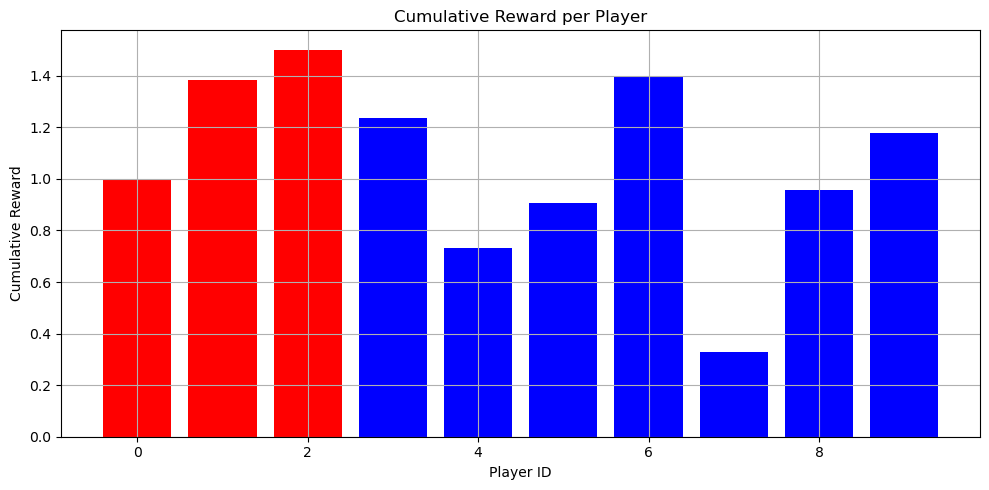

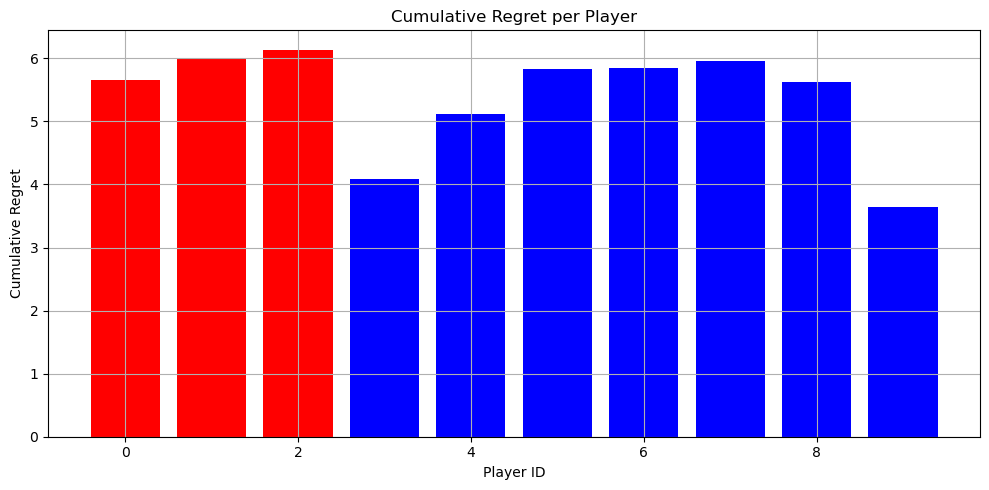

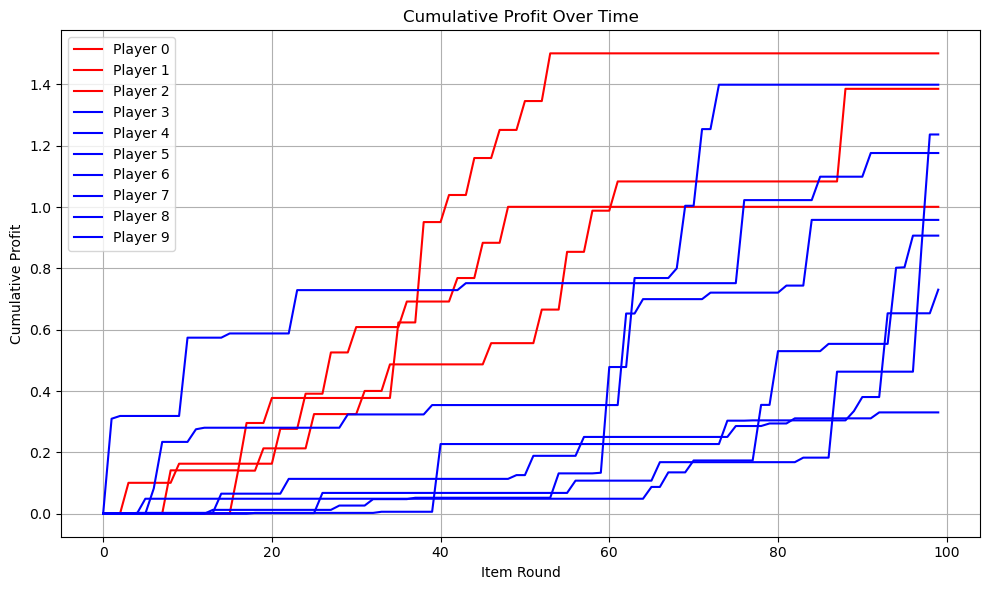

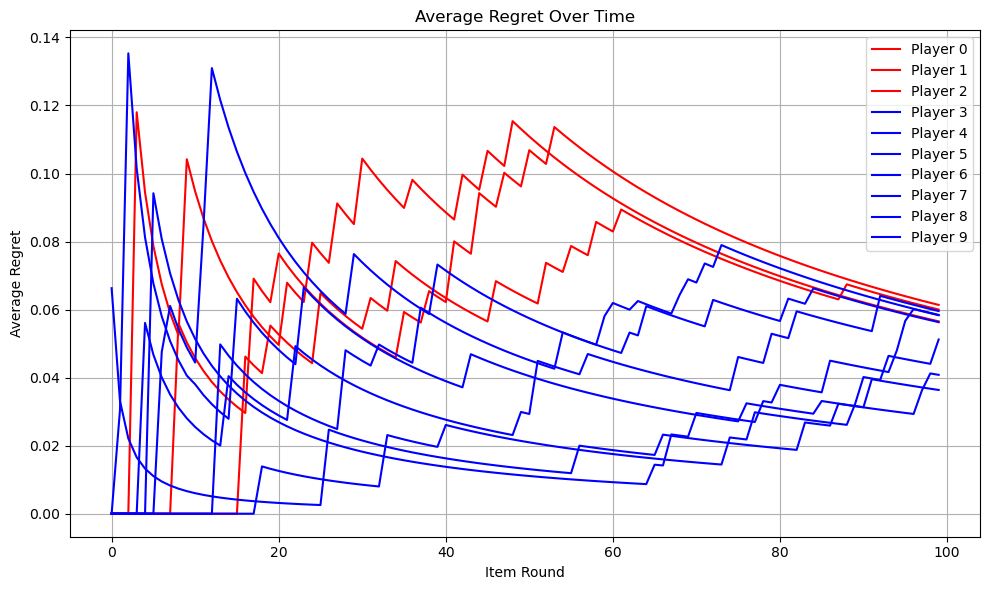

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

def simulate_budgeted_auction_game(
    save_dir='budgeted_auction_game',
    num_players=10,
    num_colluders=3,
    num_items=100,
    base_item_value=1.0,
    initial_budget=10.0,
    honest_participation_prob=0.7,
    seed=None
):
    if seed is not None:
        np.random.seed(seed)

    players = np.arange(num_players)
    colluders = players[:num_colluders] if num_colluders > 0 else np.array([], dtype=int)
    honest = players[num_colluders:]
    budgets = np.full(num_players, initial_budget)

    profits = np.zeros((num_players, num_items))
    bids_history = np.zeros((num_players, num_items))
    regrets = np.zeros((num_players, num_items))

    if num_colluders > 0:
        colluder_allocation = [colluders[i % num_colluders] for i in range(num_items)]
    else:
        colluder_allocation = [None for _ in range(num_items)]

    for t in range(num_items):
        item_value = base_item_value + 0.1 * np.random.randn()
        item_value = max(0.1, item_value)

        bids = np.zeros(num_players)
        values = np.zeros(num_players)

        for i in range(num_players):
            if budgets[i] <= 0:
                continue

            if i in colluders:
                participation_prob = min(0.2 + 0.01 * t, 1.0)
                if np.random.rand() > participation_prob:
                    continue

                if i == colluder_allocation[t]:
                    value = item_value * (1.05 + 0.05 * np.random.rand())
                    bid = min(value, budgets[i])
                else:
                    value = item_value * np.random.uniform(0.2, 0.5)
                    bid = min(value, budgets[i])
            else:
                if np.random.rand() > honest_participation_prob:
                    continue
                strategy = np.random.choice(['aggressive', 'conservative', 'random'], p=[0.4, 0.4, 0.2])
                if strategy == 'aggressive':
                    value = item_value * (0.9 + 0.1 * np.random.rand())
                elif strategy == 'conservative':
                    value = item_value * (0.6 + 0.1 * np.random.rand())
                else:
                    value = item_value * np.random.uniform(0.5, 1.0)
                bid = min(value, budgets[i])

            bids[i] = bid
            values[i] = value

        valid_bidders = np.where(bids > 0)[0]
        if len(valid_bidders) < 2:
            continue

        sorted_indices = valid_bidders[np.argsort(-bids[valid_bidders])]
        winner = sorted_indices[0]
        second_price = bids[sorted_indices[1]]
        payment = second_price
        value_winner = values[winner]

        if budgets[winner] >= payment:
            profit = value_winner - payment
            profits[winner, t] = profit
            budgets[winner] -= payment
        else:
            profit = 0

        bids_history[:, t] = bids

        for i in range(num_players):
            value = values[i]
            budget = budgets[i] + (payment if i == winner else 0)
            actual_profit = profits[i, t]

            if i == winner:
                # Could they have bid just above the 3rd highest bidder instead?
                best_lower_bid = second_price
                for alt in sorted_indices[2:]:
                    potential_payment = bids[alt]
                    if potential_payment < best_lower_bid:
                        best_lower_bid = potential_payment
                alt_payment = best_lower_bid
                alt_profit = value - alt_payment if alt_payment <= budget else actual_profit
                regret = max(alt_profit - actual_profit, 0)
            else:
                # Could they have won by bidding just above winner?
                min_required = bids[winner] + 0.01
                if min_required <= budget:
                    alt_profit = value - bids[winner]
                    regret = max(alt_profit - 0, 0)
                else:
                    regret = 0

            regrets[i, t] = regret

    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, "history_rewards.npy"), profits)
    np.save(os.path.join(save_dir, "history_bids.npy"), bids_history)
    np.save(os.path.join(save_dir, "history_regrets.npy"), regrets)

    # Plotting (unchanged)
    cumulative_rewards = profits.sum(axis=1)
    cum_profits = profits.cumsum(axis=1)

    plt.figure(figsize=(10, 5))
    for i in range(num_players):
        color = 'red' if i in colluders else 'blue'
        plt.bar(i, cumulative_rewards[i], color=color)
    plt.xlabel("Player ID")
    plt.ylabel("Cumulative Reward")
    plt.title("Cumulative Reward per Player")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "cumulative_reward_per_player.png"))
    plt.show()

    cumulative_regrets = regrets.sum(axis=1)
    plt.figure(figsize=(10, 5))
    for i in range(num_players):
        color = 'red' if i in colluders else 'blue'
        plt.bar(i, cumulative_regrets[i], color=color)
    plt.xlabel("Player ID")
    plt.ylabel("Cumulative Regret")
    plt.title("Cumulative Regret per Player")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "average_regret_per_player.png"))
    plt.show()

    plt.figure(figsize=(10, 6))
    for i in range(num_players):
        color = 'red' if i in colluders else 'blue'
        plt.plot(cum_profits[i], label=f'Player {i}', color=color)
    plt.title("Cumulative Profit Over Time")
    plt.xlabel("Item Round")
    plt.ylabel("Cumulative Profit")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "cumulative_reward_over_time.png"))
    plt.show()

    plt.figure(figsize=(10, 6))
    for i in range(num_players):
        color = 'red' if i in colluders else 'blue'
        avg_regret = np.cumsum(regrets[i]) / (np.arange(1, num_items + 1))
        plt.plot(avg_regret, label=f'Player {i}', color=color)
    plt.title("Average Regret Over Time")
    plt.xlabel("Item Round")
    plt.ylabel("Average Regret")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "average_regret_per_round.png"))
    plt.show()

    return save_dir


# === Sample usage ===
if __name__ == "__main__":
    simulate_budgeted_auction_game()
